# Iceberg Figures for Cosine and Retrieval
Make tables related to the performance of ICEBERG on cosine similarity

In [1]:
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
from pathlib import Path
import matplotlib

from collections import defaultdict
from scipy.stats import sem

set_style()

In [2]:
dataset_names = ["nist20"]

# Define
results_folder = Path("../results/figs_iceberg/weave_acc/")

results_folder.mkdir(exist_ok=True, parents=True)

In [3]:
a = pd.read_csv(f"../results/graff_ms_baseline_nist20/split_1_rnd1/preds/pred_eval_grouped_ion_type.tsv", sep='\t')
b = pd.read_csv(f"../results/graff_ms_baseline_nist20/split_1_rnd1/retrieval_nist20_split_1_50/rerank_eval_grouped_ion_cos.tsv", sep='\t')
pd.concat((a, None), axis=1).columns

Index(['Unnamed: 0', 'cos_sim', 'cos_sim_zero_pep', 'mse', 'entropy_sim',
       'frac_valid', 'overlap_coeff', 'coverage', 'len_targ', 'len_pred',
       'compound_mass', 'num_examples'],
      dtype='object')

In [4]:
def weighted_group_average(inp_df):
    # rm the current "avg" row
    df_filtered = inp_df[inp_df.iloc[:, 0] != 'avg']

    # Filter positive and negative rows
    positive_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('+')]
    negative_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('-')]

    def weighted_avg(df):
        weights = df['num_examples']
        result = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            result[col] = np.average(df[col], weights=weights)
        return result
    
    # List of all original columns
    columns = inp_df.columns

    # Create new row dictionaries and include labels for 'Unnamed: 0'
    def create_row_dict(weighted_dict, label, all_columns):
        # For each column in the original DataFrame, use the weighted value if available, otherwise NaN.
        row = {col: weighted_dict[col] if col in weighted_dict else np.nan for col in all_columns}
        row[columns[0]] = label
        return row

    
    # Calculate weighted averages for each group and create new rows
    # 6, 3/4, 9/10 are the current experiment setup (scaffold split does not have [M-H-CO2]- in test set)
    weighted_df = []
    if len(positive_rows) == 6:
        weighted_avg_positive = weighted_avg(positive_rows)
        wp_row = create_row_dict(weighted_avg_positive, 'pos_avg', columns)
        weighted_df.append(wp_row)
    if len(negative_rows) == 3 or len(negative_rows) == 4: 
        weighted_avg_negative = weighted_avg(negative_rows)
        wn_row = create_row_dict(weighted_avg_negative, 'neg_avg', columns)
        weighted_df.append(wn_row)
    if len(df_filtered) == 9 or len(df_filtered) == 10:
        weighted_avg_general  = weighted_avg(df_filtered)
        wg_row = create_row_dict(weighted_avg_general,  'avg',  columns)
        weighted_df.append(wg_row)   

    # Create a DataFrame for these new rows
    weighted_df = pd.DataFrame(weighted_df)

    # Concatenate the new rows with the original DataFrame
    out_df = pd.concat([df_filtered, weighted_df], ignore_index=True)
    
    return out_df

In [5]:
names = [
    "CFM-ID",
    "Graff-MS",
    "MassFormer",
    "FraGNNet",
    "ICEBERG (Goldman'24)",
    "ICEBERG (Ours)",
]

all_adducts = ['[M+H]+', '[M-H2O+H]+', '[M-H4O2+H]+', '[M+Na]+', '[M+K]+', '[M+H3N+H]+', # pos
               '[M-H]-', '[M+Cl]-', '[M-H-H2O]-', '[M-H-CO2]-'] # neg

dataset_to_res = {}
for dataset_name in dataset_names:
    for split_name in ['split_1', 'scaffold_1']:
        tsv_files = defaultdict(lambda : [])
        for seed in [1,2,3]:    
            results_files = [
                f"../results/cfm_id_{dataset_name}/{split_name}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/graff_ms_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/massformer_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/fragnet_preprint_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../../ms-pred-legacy/results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
            ]
            for i, j in zip(names, results_files):
                if Path(j).exists():
                    cos_df = pd.read_csv(j, sep='\t')
                else:
                    cos_df = None
                retrieval_path_entr = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_entropy.tsv'
                retrieval_path_cos = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_cos.tsv'
                if retrieval_path_entr.exists():
                    retrieval_df = pd.read_csv(retrieval_path_entr, sep='\t')
                elif retrieval_path_cos.exists():
                    retrieval_df = pd.read_csv(retrieval_path_cos, sep='\t')
                else:
                    retrieval_df = None
                
                cos_df = weighted_group_average(cos_df)
                if retrieval_df is not None:
                    retrieval_df = weighted_group_average(retrieval_df)
                
                concat_df = pd.concat((cos_df, retrieval_df), axis=1)
                tsv_files[i].append(concat_df)

        dataset_to_res[f"{split_name}_{dataset_name}"] = tsv_files

In [6]:
adduct_to_df = {}
for adduct_type in all_adducts + ['pos_avg', 'neg_avg', 'avg']:
    out_df = []
    for dataset_name, tsv_files in dataset_to_res.items():
        for k, v in tsv_files.items():
            interested_rows = [vv[vv.iloc[:, 0] == adduct_type] for vv in v]
            if any([len(row) == 0 for row in interested_rows]):
                continue
            def get_val(key):
                vals = []
                for row in interested_rows:
                    if key in row:
                        vals.append(row[key].item())
                return vals
            new_entry = {
                "Method": k,
                "Cosine sim.": np.mean(get_val('cos_sim')),
                "Cosine sim. 95%": 1.96 * sem(get_val('cos_sim')),

                "Cosine sim. (no PEP)": np.mean(get_val('cos_sim_zero_pep')),
                "Cosine sim. 95% (no PEP)": 1.96 * sem(get_val('cos_sim_zero_pep')),

                "Entropy sim.": np.mean(get_val('entropy_sim')),
                "Entropy sim. 95%": 1.96 * sem(get_val('entropy_sim')),

                "Coverage": np.mean(get_val('coverage')),
                "Coverage 95%": 1.96 * sem(get_val('coverage')),

                # The way of computing validity in this code base is outdated
                #"Valid": np.mean(get_val('frac_valid')),
                #"Valid 95%": 1.96 * sem(get_val('frac_valid')),

                "Dataset": dataset_name,
            }
            new_entry.update({
                f"Top_{i} Retrieval": np.mean(get_val(f"top_{i}")) for i in range(1, 11)
            })
            new_entry.update({
                f"Top_{i} Retrieval 95%": 1.96 * sem(get_val(f"top_{i}")) for i in range(1, 11)
            })
            out_df.append(new_entry)
    out_df = pd.DataFrame(out_df)

    # Replace nan with 0 
    out_df = out_df.fillna(0)
    
    adduct_to_df[adduct_type] = out_df


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
for adduct_type, out_df in adduct_to_df.items():
    # rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
    out_df["Cosine sim. orig"] = out_df["Cosine sim."] 

    out_df["Cosine sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Cosine sim."], out_df["Cosine sim. 95%"])
    ]
    # Same for entropy
    out_df["Entropy sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Entropy sim."], out_df["Entropy sim. 95%"])
    ]
    # Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
    out_df["Coverage"] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Coverage"], out_df["Coverage 95%"])
    ]
    # Rewrite all top_K retrieval accuracy columns
    for i in range(1, 11):
    #     out_df[f"Top_{i} Retrieval orig"] = out_df[f"Top_{i} Retrieval"]
        out_df[f"Top-{i}"] = [
            rf"${i:.3f} \pm {j:.3f}$"
            for i, j in zip(out_df[f"Top_{i} Retrieval"], out_df[f"Top_{i} Retrieval 95%"])
        ]

In [8]:
# select adduct type to process and report
out_df = adduct_to_df['[M+H]+']  # [M+H]+ / pos_avg / neg_avg / avg

# Update names
names = list(out_df['Method'].unique())

out_df

,Method,Cosine sim.,Cosine sim. 95%,Cosine sim. (no PEP),Cosine sim. 95% (no PEP),Entropy sim.,Entropy sim. 95%,Coverage,Coverage 95%,Dataset,...,Top-1,Top-2,Top-3,Top-4,Top-5,Top-6,Top-7,Top-8,Top-9,Top-10
0,CFM-ID,$0.470 \pm 0.000$,7.693453e-17,0.470696,0.000000,$0.427 \pm 0.000$,0.000000,$0.261 \pm 0.000$,0.000000e+00,split_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
1,Graff-MS,$0.565 \pm 0.001$,1.389130e-03,0.565187,0.001389,$0.529 \pm 0.001$,0.001179,$0.740 \pm 0.001$,6.337984e-04,split_1_nist20,...,$0.211 \pm 0.004$,$0.365 \pm 0.009$,$0.472 \pm 0.015$,$0.551 \pm 0.013$,$0.608 \pm 0.005$,$0.655 \pm 0.006$,$0.690 \pm 0.004$,$0.724 \pm 0.008$,$0.754 \pm 0.010$,$0.776 \pm 0.009$
2,MassFormer,$0.632 \pm 0.001$,6.916828e-04,0.631474,0.000683,$0.605 \pm 0.000$,0.000103,$0.787 \pm 0.001$,7.162337e-04,split_1_nist20,...,$0.252 \pm 0.001$,$0.422 \pm 0.002$,$0.539 \pm 0.005$,$0.617 \pm 0.007$,$0.675 \pm 0.004$,$0.724 \pm 0.005$,$0.761 \pm 0.008$,$0.794 \pm 0.010$,$0.822 \pm 0.005$,$0.843 \pm 0.006$
3,FraGNNet,$0.717 \pm 0.001$,1.131607e-03,0.000000,0.000000,$0.000 \pm 0.000$,0.000000,$0.000 \pm 0.000$,0.000000e+00,split_1_nist20,...,$0.238 \pm 0.000$,$0.000 \pm 0.000$,$0.504 \pm 0.000$,$0.000 \pm 0.000$,$0.652 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.831 \pm 0.000$
4,ICEBERG (Goldman'24),$0.754 \pm 0.002$,1.706714e-03,0.720421,0.001994,$0.700 \pm 0.001$,0.000815,$0.809 \pm 0.001$,1.458599e-03,split_1_nist20,...,$0.251 \pm 0.016$,$0.454 \pm 0.004$,$0.576 \pm 0.006$,$0.654 \pm 0.004$,$0.711 \pm 0.007$,$0.753 \pm 0.007$,$0.783 \pm 0.005$,$0.810 \pm 0.001$,$0.833 \pm 0.007$,$0.850 \pm 0.009$
5,ICEBERG (Ours),$0.794 \pm 0.002$,2.195509e-03,0.793819,0.002199,$0.763 \pm 0.001$,0.001312,$0.856 \pm 0.000$,4.687100e-04,split_1_nist20,...,$0.400 \pm 0.008$,$0.611 \pm 0.013$,$0.721 \pm 0.010$,$0.790 \pm 0.007$,$0.829 \pm 0.006$,$0.859 \pm 0.005$,$0.881 \pm 0.006$,$0.900 \pm 0.009$,$0.913 \pm 0.008$,$0.923 \pm 0.007$
6,CFM-ID,$0.450 \pm 0.000$,0.000000e+00,0.450495,0.000000,$0.401 \pm 0.000$,0.000000,$0.228 \pm 0.000$,3.846727e-17,scaffold_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
7,Graff-MS,$0.470 \pm 0.001$,1.248363e-03,0.470040,0.001293,$0.448 \pm 0.001$,0.000614,$0.706 \pm 0.001$,1.041536e-03,scaffold_1_nist20,...,$0.143 \pm 0.004$,$0.270 \pm 0.002$,$0.368 \pm 0.008$,$0.450 \pm 0.006$,$0.518 \pm 0.002$,$0.569 \pm 0.002$,$0.614 \pm 0.003$,$0.650 \pm 0.000$,$0.687 \pm 0.002$,$0.716 \pm 0.002$
8,MassFormer,$0.526 \pm 0.002$,1.868072e-03,0.525730,0.001905,$0.512 \pm 0.002$,0.002040,$0.742 \pm 0.002$,1.510981e-03,scaffold_1_nist20,...,$0.184 \pm 0.008$,$0.328 \pm 0.005$,$0.431 \pm 0.001$,$0.512 \pm 0.005$,$0.575 \pm 0.004$,$0.629 \pm 0.004$,$0.674 \pm 0.006$,$0.712 \pm 0.004$,$0.749 \pm 0.004$,$0.775 \pm 0.004$
9,FraGNNet,$0.654 \pm 0.003$,3.394820e-03,0.000000,0.000000,$0.000 \pm 0.000$,0.000000,$0.000 \pm 0.000$,0.000000e+00,scaffold_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$


In [9]:
# only build scaffold split and normal split for NIST

out_df_temp = out_df[out_df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Entropy sim."
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = ["Cosine sim.", "Entropy sim."]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]


# Sort columns and make time last

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Comparing NIST scaffold vs. random spllit cosine similarity",
    label="tab:scaffold",
    escape=False,
)
print(latex)

# Output to file "nist_scaffold_cosine.txt" in result folder
with open(results_folder / "nist_scaffold_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Comparing NIST scaffold vs. random spllit cosine similarity}
\label{tab:scaffold}
\begin{tabular}{lllll}
\toprule
Dataset & \multicolumn{2}{r}{split_1_nist20} & \multicolumn{2}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Cosine sim. & Entropy sim. \\
\midrule
CFM-ID & $0.470 \pm 0.000$ & $0.427 \pm 0.000$ & $0.450 \pm 0.000$ & $0.401 \pm 0.000$ \\
Graff-MS & $0.565 \pm 0.001$ & $0.529 \pm 0.001$ & $0.470 \pm 0.001$ & $0.448 \pm 0.001$ \\
MassFormer & $0.632 \pm 0.001$ & $0.605 \pm 0.000$ & $0.526 \pm 0.002$ & $0.512 \pm 0.002$ \\
FraGNNet & $0.717 \pm 0.001$ & $0.000 \pm 0.000$ & $0.654 \pm 0.003$ & $0.000 \pm 0.000$ \\
ICEBERG (Goldman'24) & $0.754 \pm 0.002$ & $0.700 \pm 0.001$ & $0.701 \pm 0.001$ & $0.641 \pm 0.004$ \\
ICEBERG (Ours) & $0.794 \pm 0.002$ & $0.763 \pm 0.001$ & $0.735 \pm 0.000$ & $0.708 \pm 0.000$ \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Coverage",
        "Entropy sim.",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)


metric_order = {"Cosine sim.": 1, "Entropy sim.": 2, "Coverage": 3}
metric_order = ["Cosine sim.", "Entropy sim.", "Coverage"]
dataset_order = {"split_1_nist20": 1, "scaffold_1_nist20": 2}
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False
)
print(latex)


# Output to file "all_cosine.txt" in result folder
with open(results_folder / "all_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lllllll}
\toprule
Dataset & \multicolumn{3}{r}{split_1_nist20} & \multicolumn{3}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Coverage & Cosine sim. & Entropy sim. & Coverage \\
\midrule
CFM-ID & $0.470 \pm 0.000$ & $0.427 \pm 0.000$ & $0.261 \pm 0.000$ & $0.450 \pm 0.000$ & $0.401 \pm 0.000$ & $0.228 \pm 0.000$ \\
Graff-MS & $0.565 \pm 0.001$ & $0.529 \pm 0.001$ & $0.740 \pm 0.001$ & $0.470 \pm 0.001$ & $0.448 \pm 0.001$ & $0.706 \pm 0.001$ \\
MassFormer & $0.632 \pm 0.001$ & $0.605 \pm 0.000$ & $0.787 \pm 0.001$ & $0.526 \pm 0.002$ & $0.512 \pm 0.002$ & $0.742 \pm 0.002$ \\
FraGNNet & $0.717 \pm 0.001$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.654 \pm 0.003$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
ICEBERG (Goldman'24) & $0.754 \pm 0.002$ & $0.700 \pm 0.001$ & $0.809 \pm 0.001$ & $0.701 \pm 0.001$ & $0.641 \pm 0.004$ & $0.790 \pm 0.001$ \\
ICEBERG (Ours) & $0.794 \pm 0.002$ & $0.

In [11]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Top-1",
        "Top-2",
        "Top-3",
        "Top-4",
        "Top-5",
        "Top-6",
        "Top-7",
        "Top-8",
        "Top-9",
        "Top-10",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20"]  # random split

new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_random = out_df_pivot_sorted.loc[:, new_index]

out_df_pivot_random.index.name = None
latex = out_df_pivot_random.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)

dataset_order = ["scaffold_1_nist20"]  # scaffold split
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_scaffold = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_scaffold.index.name = None
latex = out_df_pivot_scaffold.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)


\begin{table}
\caption{Retrieval accuracy accuracy}
\label{tab:retrieval_acc}
\begin{tabular}{lllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
CFM-ID & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
Graff-MS & $0.211 \pm 0.004$ & $0.365 \pm 0.009$ & $0.472 \pm 0.015$ & $0.551 \pm 0.013$ & $0.608 \pm 0.005$ & $0.655 \pm 0.006$ & $0.690 \pm 0.004$ & $0.724 \pm 0.008$ & $0.754 \pm 0.010$ & $0.776 \pm 0.009$ \\
MassFormer & $0.252 \pm 0.001$ & $0.422 \pm 0.002$ & $0.539 \pm 0.005$ & $0.617 \pm 0.007$ & $0.675 \pm 0.004$ & $0.724 \pm 0.005$ & $0.761 \pm 0.008$ & $0.794 \pm 0.010$ & $0.822 \pm 0.005$ & $0.843 \pm 0.006$ \\
FraGNNet & $0.238 \pm 0.000$ & $0.000 \pm 0.000$ & $0.504 \pm 0.000$ & $0.000 \pm 0.000$ & $0.652 \pm 0.0

In [12]:
method_colors

{'CFM-ID': '#D7D7D7',
 'MassFormer': '#7C9D97',
 'Graff-MS': '#A7B7C3',
 'FraGNNet': '#7B94CC',
 "ICEBERG (Goldman'24)": '#E9B382',
 'ICEBERG (Ours)': '#FFD593'}

/tmp/ipykernel_3185472/2466652942.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right")


[Text(0, 0, 'CFM-ID'),
 Text(1, 0, 'Graff-MS'),
 Text(2, 0, 'MassFormer'),
 Text(3, 0, 'FraGNNet'),
 Text(4, 0, "ICEBERG (Goldman'24)"),
 Text(5, 0, 'ICEBERG (Ours)')]

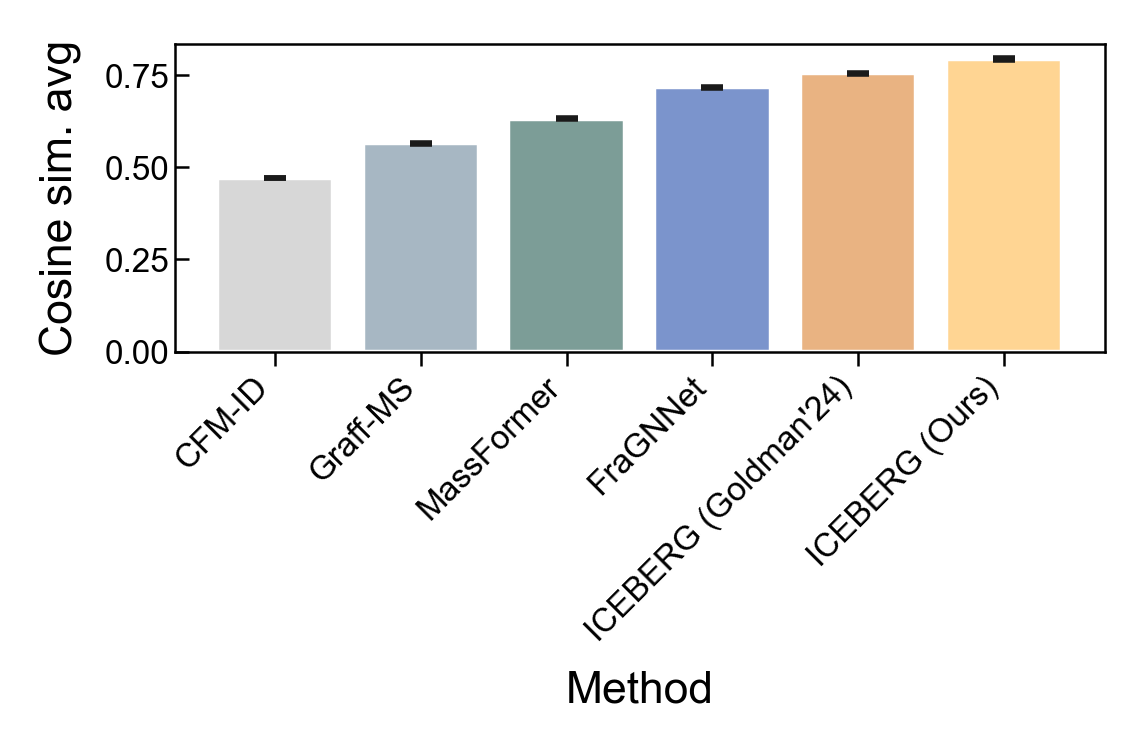

In [13]:
## Define Cosine sim bar plots

dataset = "split_1_nist20"
dataset_sub = out_df[["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]].query(
    f"Dataset == '{dataset}'"
)
dataset_sub.set_index("Method", inplace=True)
fig = plt.figure(figsize=(3, 1), dpi=400)

ax = fig.gca()
dataset_sub = dataset_sub.loc[names]
sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
errors = dataset_sub[["Cosine sim. 95%"]].values.flatten()
method_names = dataset_sub.index.values

ax.bar(method_names, sim, color=[method_colors[i] for i in method_names], 
    # errors
    yerr=errors,
    # Add style to make them visible
    capsize=2,
    
)

# Add 95% conf bars



ax.set_ylabel("Cosine sim. avg")
ax.set_xlabel("Method")
# Rotate x tick labels
ax.set_xticklabels(method_names, rotation=45, ha="right")

/tmp/ipykernel_3185472/795742642.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")
/tmp/ipykernel_3185472/795742642.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")


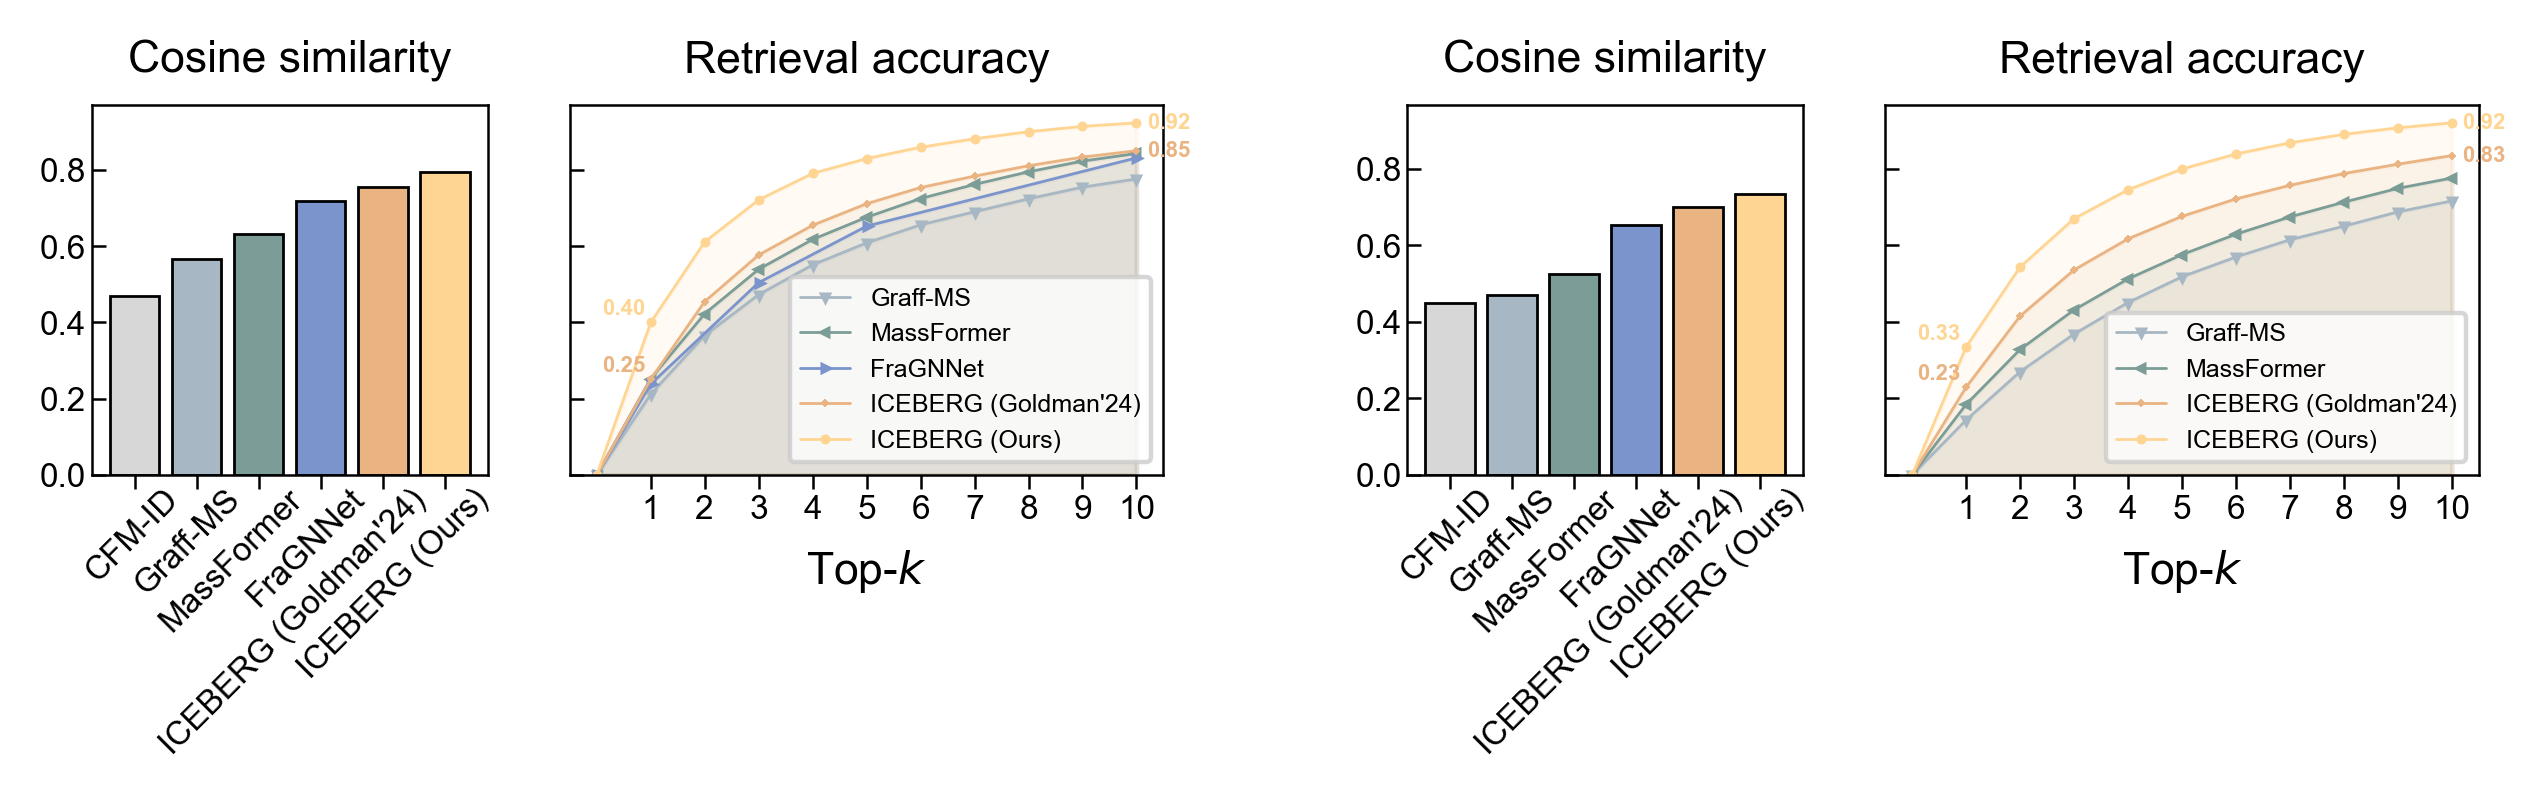

In [14]:
# Plot cosine similarities and time for 2 datasets
# define subplots
gridspec = dict(hspace=0.0, width_ratios=[1, 1.5, 0.2, 1, 1.5])
fig, axes = plt.subplots(
    1, 5, figsize=(7.7, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "InChIKey", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]
for ind, (cur_axes, dataset) in enumerate(zip([axes[0:2], axes[3:5]], plot_datasets)):
    # Cosine similarity plot
    ax = cur_axes[0]

    dataset_sub = out_df[
        ["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]
    ].query(f"Dataset == '{dataset}'")
    dataset_sub.set_index("Method", inplace=True)
    dataset_sub = dataset_sub.loc[names]
    sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
    _sem = dataset_sub[["Cosine sim. 95%"]].values.flatten()

    # Using sem compute 95% confidence interval and plot error bars
    ci = _sem * 1.96

    method_names = dataset_sub.index.values

    ax.bar(
        method_names,
        sim,
        color=[method_colors[i] for i in method_names],
        edgecolor="black",
        linewidth=0.5,
#         yerr=ci,
        capsize=1.5,
        error_kw=dict(lw=0.5, capsize=1.5, capthick=0.5),
    )
    ax.set_title("Cosine similarity")
    # ax.set_xlabel("Method")
    # Rotate x tick labels
    ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")
    dx = 5/72.; dy = 2/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # apply offset transform to all x ticklabels.
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
#     ax.set_title(plt_dataset_names.get(dataset))
    ax.yaxis.labelpad = 1
    
    # Retrieval acc plot
    ax = cur_axes[1]
    for method in names:
        sub_df = out_df[
            (out_df["Method"] == method) & (out_df["Dataset"] == dataset)
        ]
        topk, accs, error = [0], [0], [0]
        for i in range(1, 11):
            acc = sub_df[f"Top_{i} Retrieval"].item()
            err = sub_df[f"Top_{i} Retrieval 95%"].item()
            if acc != 0:
                topk.append(i)
                accs.append(acc)
                if err != 0:
                    error.append(err)
        marker = method_markers[method]
        if len(accs) > 1:
            ax.plot(
                topk,
                accs,
                color=method_colors[method],
                linewidth=0.5,
                label=method,
                marker=marker,
                markersize=0.8,
            )
            
            ax.legend(fontsize=4.5)
            
            ax.fill_between(
                topk,
                np.zeros_like(accs),
                np.array(accs),
                alpha=0.1,
                color=method_colors[method],
            )
        
        if method in ['ICEBERG (Ours)', 'ICEBERG (Goldman\'24)']:
            ax.text(topk[1]-0.1, accs[1]+0.02, f'{accs[1]:.2f}', 
                    horizontalalignment='right', fontsize=4, color=method_colors[method], fontweight='bold')
            ax.text(topk[-1]+0.2, accs[-1], f'{accs[-1]:.2f}', 
                    horizontalalignment='left', verticalalignment='center', fontsize=4, color=method_colors[method], fontweight='bold')
        
#         if len(error) > 1:
#             ax.fill_between(
#                 topk,
#                 np.array(accs) - np.array(error),
#                 np.array(accs) + np.array(error),
#                 alpha=0.2,
#                 color=method_colors[method],
#             )
    ax.xaxis.set_ticks(np.arange(1, 11))
    ax.set_xlabel("Top-$k$", fontfamily='arial')
    ax.set_title("Retrieval accuracy")

axes[0].get_shared_y_axes().join(axes[0], axes[1])
axes[1].set_xticklabels(list(range(1, 11)))
axes[1].set_yticklabels([])
axes[2].set_visible(False)
axes[3].get_shared_y_axes().join(axes[3], axes[4])
axes[4].set_xticklabels(list(range(1, 11)))
axes[4].set_yticklabels([])


# Save fig to file
fig.savefig(
    results_folder / "cosine_retrieval.pdf", bbox_inches="tight", transparent=True
)

In [15]:
# per-adduct type result for ICEBERG
all_dfs = []
for adduct_type in all_adducts:
    df = adduct_to_df[adduct_type]
    out_df_temp = df[df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
    out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
    out_df_pivot = out_df_temp.pivot_table(
        index="Method",
        columns="Dataset",
        values=[
            f"Top-{i}" for i in range(1, 11)
        ],
        aggfunc=lambda x: x,
    )
#     out_df_pivot.index.name = 'Adduct type'
    out_df_pivot.rename(index={'ICEBERG (Ours)': adduct_type}, inplace=True)
    all_dfs.append(out_df_pivot)
out_df_pivot = pd.concat(all_dfs, axis=0)
out_df_pivot = out_df_pivot.fillna('-') # fill nan with '-'

out_df_pivot_sorted = out_df_pivot.swaplevel(0, 1, axis=1).round(3)


metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", None]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]
out_df_pivot_sorted

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="NIST adduct type retrieavl accuracy",
    label="tab:retrieval_per_adduct",
    escape=False,
)
print(latex)

\begin{table}
\caption{NIST adduct type retrieavl accuracy}
\label{tab:retrieval_per_adduct}
\begin{tabular}{lllllllllllllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} & \multicolumn{10}{r}{scaffold_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
[M+H]+ & $0.400 \pm 0.008$ & $0.611 \pm 0.013$ & $0.721 \pm 0.010$ & $0.790 \pm 0.007$ & $0.829 \pm 0.006$ & $0.859 \pm 0.005$ & $0.881 \pm 0.006$ & $0.900 \pm 0.009$ & $0.913 \pm 0.008$ & $0.923 \pm 0.007$ & $0.335 \pm 0.005$ & $0.543 \pm 0.004$ & $0.669 \pm 0.006$ & $0.745 \pm 0.002$ & $0.799 \pm 0.004$ & $0.838 \pm 0.006$ & $0.867 \pm 0.005$ & $0.890 \pm 0.006$ & $0.907 \pm 0.009$ & $0.920 \pm 0.009$ \\
[M-H2O+H]+ & $0.238 \pm 0.007$ & $0.443 \pm 0.020$ & $0.556 \pm 0.014$ & $0.634 \pm 0.005$ & $0.685 \pm 0.009$ & $0.726 \pm 0.008$ & $0.754 \pm 0.011$ & $0.776 \pm 0.016$ & $0.802 \pm 

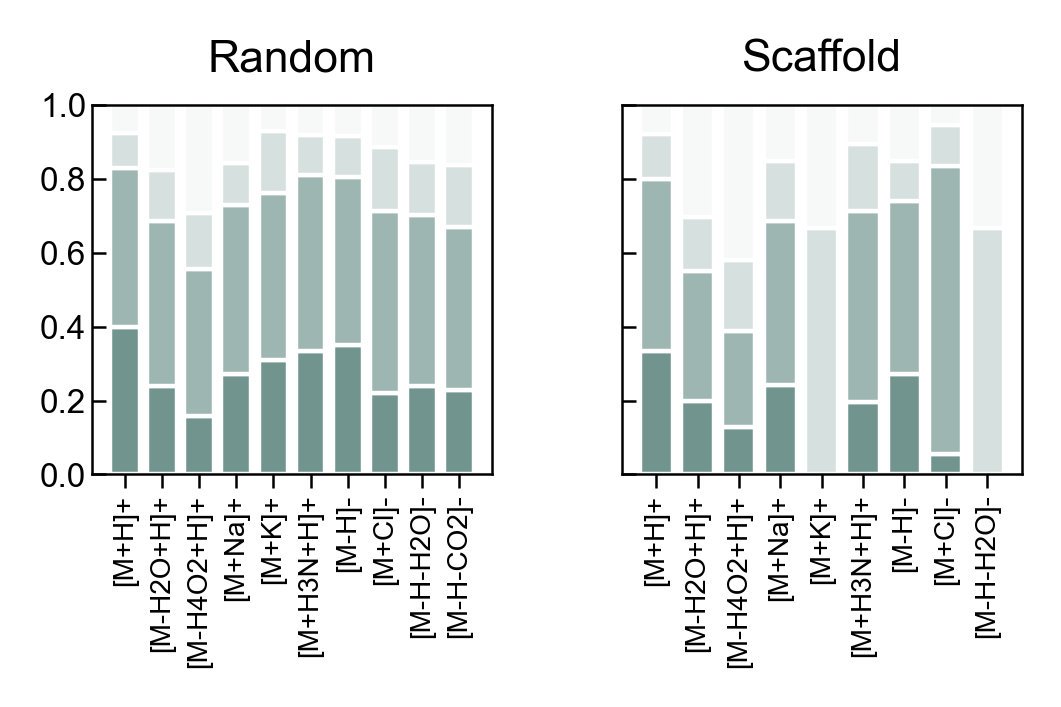

In [16]:
gridspec = dict(hspace=0.0, width_ratios=[1, 0.05, 1])
fig, axes = plt.subplots(
    1, 3, figsize=(3, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "Random", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]

for ind, (ax, dataset) in enumerate(zip([axes[0], axes[2]], plot_datasets)):
    accs = []
    active_adducts = []
    for adduct_type in all_adducts:
        df = adduct_to_df[adduct_type]
        out_df_temp = df[df["Dataset"].isin([dataset])]
        out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
        if len(out_df_temp) > 0:
            accs.append([out_df_temp['Top_1 Retrieval'].item(), 
                         out_df_temp['Top_5 Retrieval'].item(), 
                         out_df_temp['Top_10 Retrieval'].item()])
            active_adducts.append(adduct_type)
    accs = np.array(accs)
    ax.bar(np.arange(len(active_adducts)), accs[:, 0], bottom=np.zeros(len(active_adducts)), color='#71958e')
    ax.bar(np.arange(len(active_adducts)), accs[:, 1] - accs[:, 0], bottom=accs[:, 0], color='#9eb6b2')
    ax.bar(np.arange(len(active_adducts)), accs[:, 2] - accs[:, 1], bottom=accs[:, 1], color='#d6e0de')
    ax.bar(np.arange(len(active_adducts)), np.ones(len(active_adducts)) - accs[:, 2], bottom=accs[:, 2], color='#f7f9f9')
    ax.set_xticks(range(len(active_adducts)))  # Ensure tick positions match the labels
    ax.set_xticklabels(active_adducts, fontsize=5)
    ax.tick_params(axis='x', labelrotation=90)
    ax.yaxis.labelpad = 1
    ax.set_title(plt_dataset_names[dataset])

axes[1].set_visible(False)
axes[0].get_shared_y_axes().join(axes[0], axes[2])
axes[0].set_ylim(0, 1)
axes[2].set_yticklabels([])

fig.savefig(
    results_folder / "retrieval_by_adduct.pdf", bbox_inches="tight", transparent=True
)